# MTS Gold Price

## Import Libraries

In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px # type: ignore

In [25]:
import sys
sys.path.append('..')

In [26]:
from utils.plot import plot_time_series
from utils.preds import evaluate_preds

## Fetch Data

In [27]:
dirname = os.path.join(os.getcwd(), '..', 'data', 'Gold_Price.csv')

In [28]:
gold_price = pd.read_csv(dirname, header=0, index_col=0)
gold_price.head()

,Price,Open,High,Low,Volume,Chg%
Date,,,,,,
2025-01-06,77149,77309,77542,76545,27160,0.44
2025-01-03,76813,77246,78600,76613,60,-0.05
2025-01-02,76849,76849,76849,76849,0,0.83
2025-01-01,76214,76232,76302,76053,60,-0.02
2024-12-31,76232,75680,76970,75572,1920,0.95


## Clean the Data

In [29]:
gold_price.shape

(2848, 6)

In [30]:
# Check out if there is some NA in our dataframe
gold_price.isna().any().any()

False

In [31]:
# Let's conver the index into datetime
gold_price.index = pd.to_datetime(gold_price.index)
isinstance(gold_price.index, pd.DatetimeIndex)

True

We have to reverse the order of the index, i.e, the first date we see must be the last one in the pd.DataFrame as so on.

In [32]:
gold_price = gold_price.sort_index(ascending=True)
gold_price.head(5)

,Price,Open,High,Low,Volume,Chg%
Date,,,,,,
2014-01-01,29542,29435,29598,29340,2930,0.25
2014-01-02,29975,29678,30050,29678,3140,1.47
2014-01-03,29727,30031,30125,29539,3050,-0.83
2014-01-04,29279,29279,29279,29279,0,-1.51
2014-01-06,29119,29300,29395,29051,24380,-0.55


In [33]:
# Let's check which days are missing from a given year
year = 2023
all_days = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')
existing_days = gold_price.loc[str(year)].index.normalize() # remove the hours
missing_days = all_days.difference(existing_days)

print(f'Total number of days in {year}: {len(all_days)}')
print(f'Number of existing days in the Gold Price dataset in {year}: {len(existing_days)}')
print(f'Number of missing days in the Gold Price dataset in {year}: {len(missing_days)}')

Total number of days in 2023: 365
Number of existing days in the Gold Price dataset in 2023: 256
Number of missing days in the Gold Price dataset in 2023: 109


In [34]:
missing_weekends = missing_days[missing_days.weekday >= 5]
missing_non_weekends = missing_days[missing_days.weekday < 5]

print(f'Number of Weekend Days in {year}: {len(missing_weekends)}')
print(f'Number of Non Weekend Days in {year}: {len(missing_non_weekends)}')

Number of Weekend Days in 2023: 104
Number of Non Weekend Days in 2023: 5


The gold market does not operate on holidays or weekends.

We could fill the gaps with the technique `ffill()`, which fill with the last known value. This one is a good approach in this case, because the value doesn't change when the market is closed.

In [35]:
gold_price = gold_price.reindex(pd.date_range(gold_price.index.min(), gold_price.index.max(), freq='D'))
cols_ffill = gold_price.columns.difference(['Chg%'])
gold_price[cols_ffill] = gold_price[cols_ffill].ffill()
gold_price['Chg%'] = gold_price['Chg%'].fillna(0.0)
gold_price.head(10)

,Price,Open,High,Low,Volume,Chg%
2014-01-01,29542.0,29435.0,29598.0,29340.0,2930.0,0.25
2014-01-02,29975.0,29678.0,30050.0,29678.0,3140.0,1.47
2014-01-03,29727.0,30031.0,30125.0,29539.0,3050.0,-0.83
2014-01-04,29279.0,29279.0,29279.0,29279.0,0.0,-1.51
2014-01-05,29279.0,29279.0,29279.0,29279.0,0.0,0.00
2014-01-06,29119.0,29300.0,29395.0,29051.0,24380.0,-0.55
2014-01-07,28959.0,29130.0,29195.0,28912.0,18710.0,-0.55
2014-01-08,28934.0,28916.0,29029.0,28820.0,18140.0,-0.09
2014-01-09,28997.0,28990.0,29053.0,28865.0,15130.0,0.22
2014-01-10,29169.0,29030.0,29198.0,28960.0,15810.0,0.59


## Visualize the Gold Price and some simple statistics

In [36]:
# First date and Last date
gold_price.index.min(), gold_price.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

In [37]:
# Min value, Max value
gold_price.Price.min(), gold_price.Price.max()

(24545.0, 79257.0)

In [38]:
fig = px.line(gold_price, x=gold_price.index, y='Price', title='Evolution of the Gold Price through Time')
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Gold Price (USD)'
)
fig.show()

## Feature Engineering

In [39]:
gold_price['is_weekend'] = gold_price.index.weekday >= 5
gold_price.head(20)

,Price,Open,High,Low,Volume,Chg%,is_weekend
2014-01-01,29542.0,29435.0,29598.0,29340.0,2930.0,0.25,False
2014-01-02,29975.0,29678.0,30050.0,29678.0,3140.0,1.47,False
2014-01-03,29727.0,30031.0,30125.0,29539.0,3050.0,-0.83,False
2014-01-04,29279.0,29279.0,29279.0,29279.0,0.0,-1.51,True
2014-01-05,29279.0,29279.0,29279.0,29279.0,0.0,0.00,True
2014-01-06,29119.0,29300.0,29395.0,29051.0,24380.0,-0.55,False
2014-01-07,28959.0,29130.0,29195.0,28912.0,18710.0,-0.55,False
2014-01-08,28934.0,28916.0,29029.0,28820.0,18140.0,-0.09,False
2014-01-09,28997.0,28990.0,29053.0,28865.0,15130.0,0.22,False
2014-01-10,29169.0,29030.0,29198.0,28960.0,15810.0,0.59,False


## Create train and test sets for time series

In [40]:
timesteps = gold_price.index.to_numpy()
price = gold_price.Price.to_numpy()

In [41]:
# Create train and test splits, 80% train, 20% test
split_size = int(0.8 * len(price))

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], price[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], price[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(3219, 3219, 805, 805)

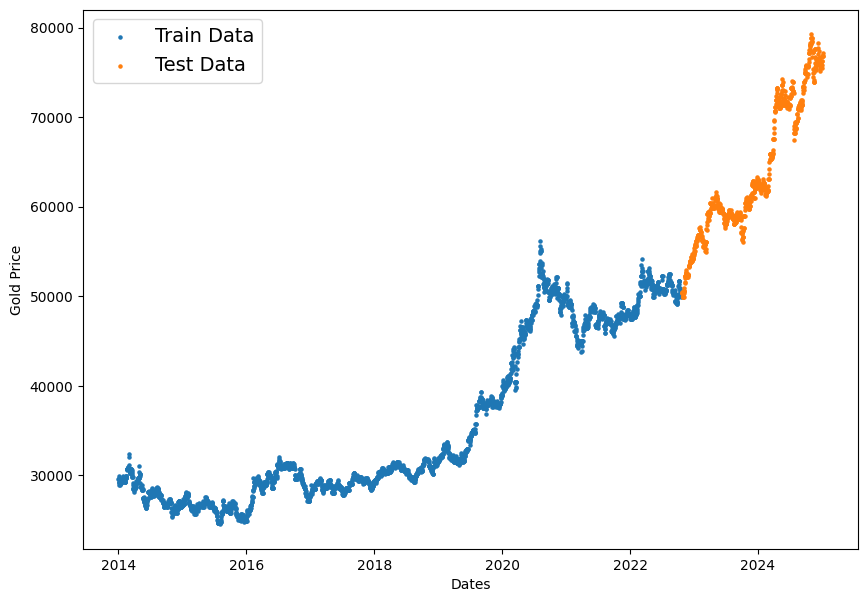

In [42]:
# Plot with train and test
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train Data')
plt.scatter(X_test, y_test, s=5, label='Test Data')
plt.xlabel('Dates')
plt.ylabel('Gold Price')
plt.legend(fontsize=14)
plt.show()

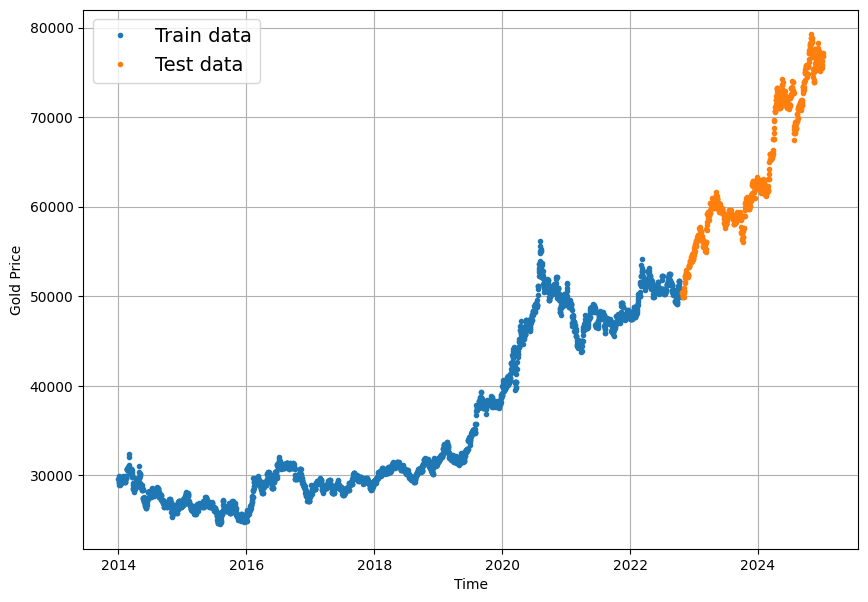

In [43]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data", xlabel='Time', ylabel='Gold Price')
plot_time_series(timesteps=X_test, values=y_test, label="Test data", xlabel='Time', ylabel='Gold Price')

## Baselines Models

### Baseline 0: Naive Forecast

$$\hat{y}_{t+1} = y_t$$

In [44]:
# Create a naive forecast
naive_preds = y_test[:-1]
naive_preds[:5]

array([50353., 50411., 50450., 49956., 49956.])

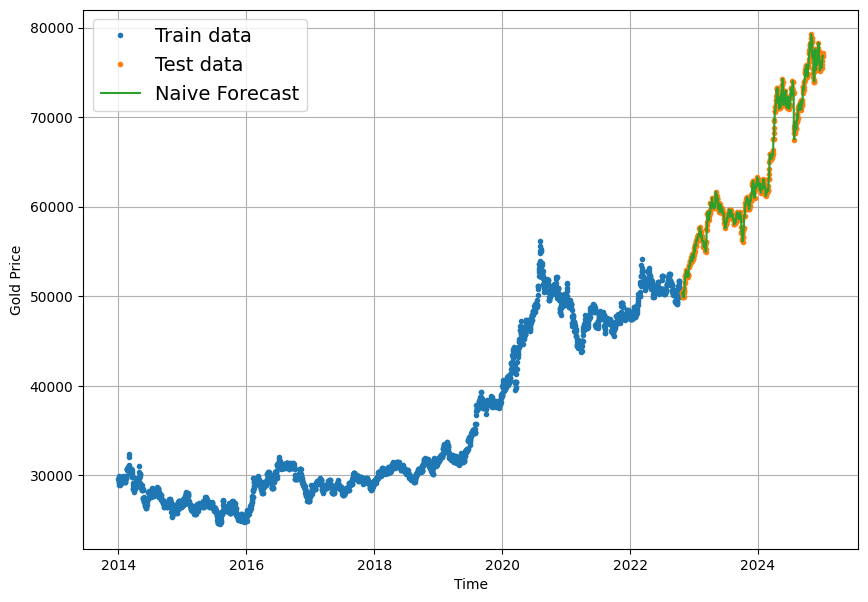

In [45]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_preds, format='-', label='Naive Forecast', xlabel='Time', ylabel='Gold Price')

In [46]:
naive_metrics = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_preds)
naive_metrics

{'mae': 233.07214, 'mse': 163311.62, 'rmse': 404.11835, 'mape': 0.3581797}

### Baseline 1: ARIMA

Bibliography: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

* **AR (Autoregression):** This emphasizes the dependent relationship between an observation and its preceding or 'lagged' observations.
* **I (Integrated):** To achieve a stationary time series, one that doesn't exhibit trend or seasonality, differencing is applied. It typically involves subtracting an observation from its preceding observation.
* **MA (Moving Average):** This component zeroes in on the relationship between an observation and the residual error from a moving average model based on lagged observations.

In [47]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.gofplots import qqplot

#### Stationarity

In [48]:
# Check for stationarity (mean and variance constant)
adf = adfuller(gold_price.Price)
print(f'ADF p-value: {adf[1]}')

ADF p-value: 0.9983635815409911


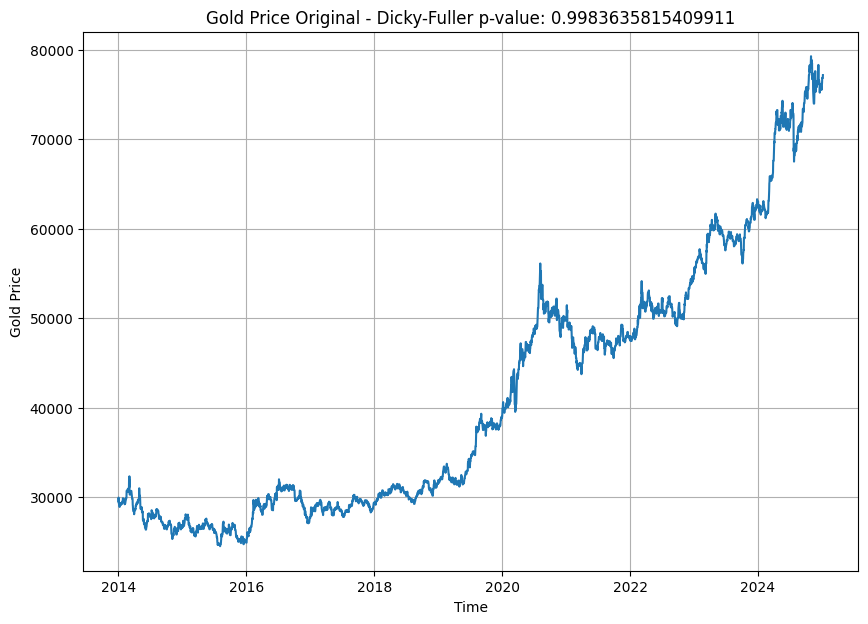

In [49]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=timesteps,
                 values=price,
                 format='-',
                 xlabel='Time',
                 ylabel='Gold Price')
plt.title(f'Gold Price Original - Dicky-Fuller p-value: {adf[1]}')
plt.show()

In [50]:
# We have to differentiate, because the p-value was greater than 0.05
gold_price_stationarity = gold_price['Price'].diff().dropna()
adf_diff = adfuller(gold_price_stationarity)
print(f'ADF p-value with 1 differentation: {adf_diff[1]}')

ADF p-value with 1 differentation: 9.21575363980092e-27


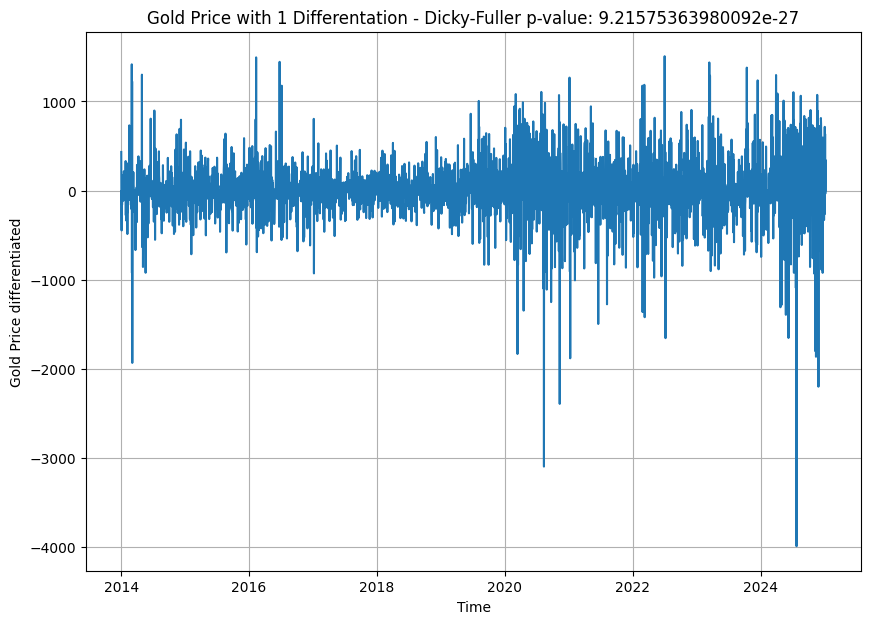

In [51]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=gold_price_stationarity.index.to_numpy(),
                 values=gold_price_stationarity.values,
                 format='-',
                 xlabel='Time',
                 ylabel='Gold Price differentiated')
plt.title(f'Gold Price with 1 Differentation - Dicky-Fuller p-value: {adf_diff[1]}')
plt.show()

#### ACF and PACF

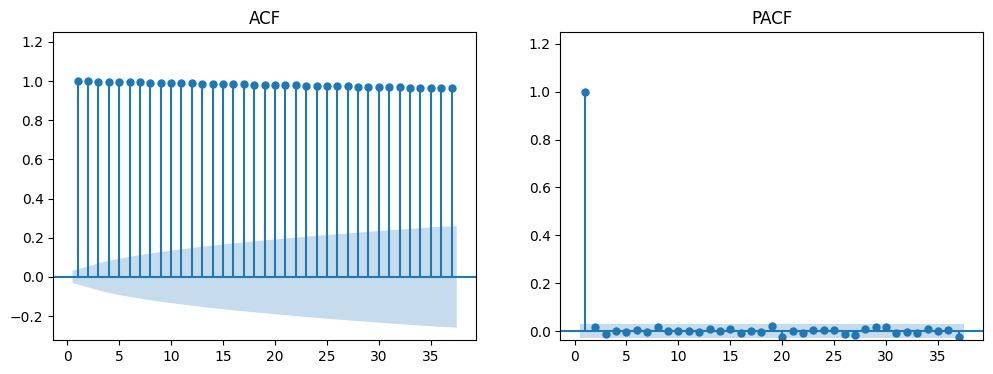

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(gold_price.Price, ax=axes[0], zero=False, auto_ylims=True, title='ACF')
plot_pacf(gold_price.Price, ax=axes[1], zero=False, auto_ylims=True, title='PACF')
plt.show()

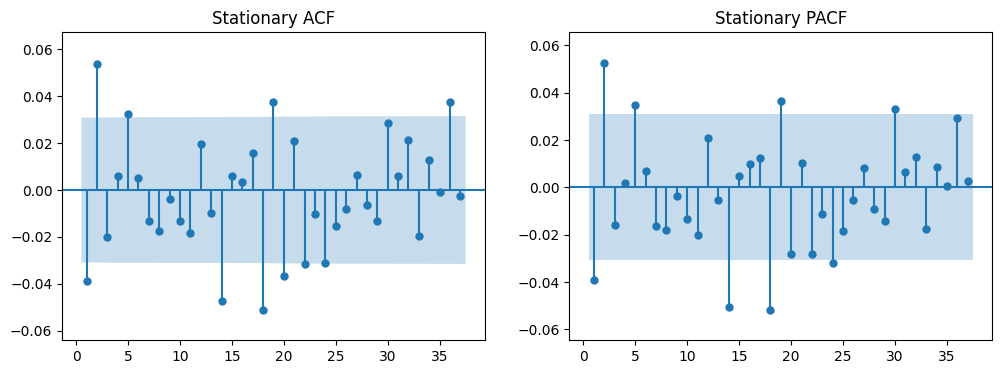

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(gold_price_stationarity, ax=axes[0], zero=False, auto_ylims=True, title='Stationary ACF')
plot_pacf(gold_price_stationarity, ax=axes[1], zero=False, auto_ylims=True, title='Stationary PACF')
plt.show()

We can try the next models:

* `ARIMA(0, 1, 0)` - **Random Walk**
* `ARIMA(1, 1, 0)`
* `ARIMA(1, 1, 1)`
* `ARIMA(1, 1, 2)`

#### Create Model

In [54]:
gold_price_train = pd.Series(y_train, index=pd.DatetimeIndex(X_train, freq='D'))
gold_price_test = pd.Series(y_test, index=pd.DatetimeIndex(X_test, freq='D'))

In [55]:
model_arima_010 = ARIMA(gold_price_train, order=(0, 1, 0))
model_arima_110 = ARIMA(gold_price_train, order=(1, 1, 0))
model_arima_111 = ARIMA(gold_price_train, order=(1, 1, 1))
model_arima_112 = ARIMA(gold_price_train, order=(1, 1, 2))

results_arima_010 = model_arima_010.fit()
results_arima_110 = model_arima_110.fit()
results_arima_111 = model_arima_111.fit()
results_arima_112 = model_arima_112.fit()

In [56]:
results_arima_010.summary(), results_arima_110.summary(), results_arima_111.summary(), results_arima_112.summary()

(<class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                 3219
 Model:                 ARIMA(0, 1, 0)   Log Likelihood              -22622.419
 Date:               vi., 05 sep. 2025   AIC                          45246.838
 Time:                        15:51:26   BIC                          45252.914
 Sample:                    01-01-2014   HQIC                         45249.015
                          - 10-24-2022                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2      7.474e+04    673.518    110.966      0.000    7.34e+04    7.61e+04
 Ljung-Box (L1) (Q):                  11.72   Jarque-Bera (JB):       

The best ARIMA model looking at the AIC metric is: `ARIMA(1, 1, 0)`.

Now, we will make the predictions using the **walk-forward** technique.

In [57]:
history = list(gold_price_train)
arima_preds = []
for obs in gold_price_test:
    model = ARIMA(history, order=(1, 1, 0))
    results = model.fit()
    pred = results.forecast()[0]
    arima_preds.append(pred)
    history.append(obs) # take in the real observation

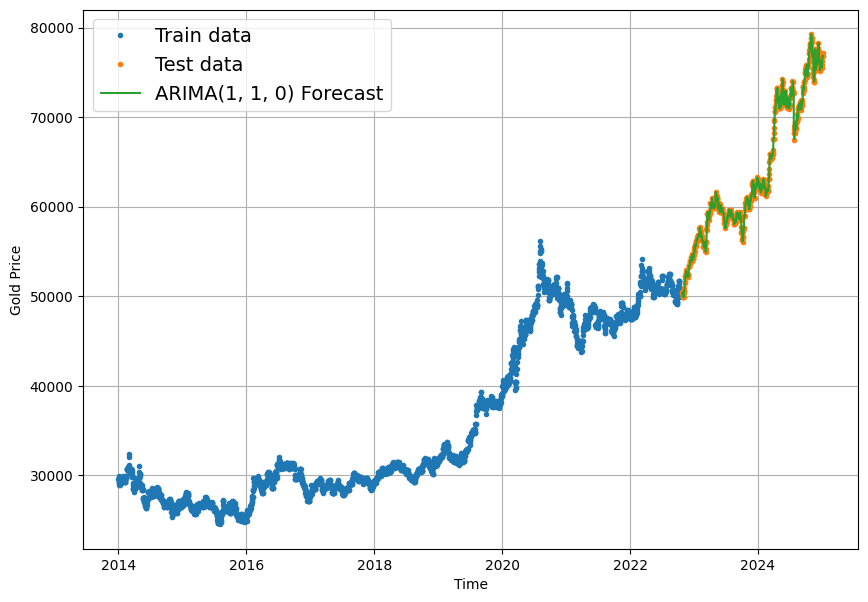

In [58]:
# Plot ARIMA(1, 1, 0) forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test, values=arima_preds, format='-', label='ARIMA(1, 1, 0) Forecast', xlabel='Time', ylabel='Gold Price')

In [59]:
arima_metrics = evaluate_preds(y_true=y_test,
                               y_pred=arima_preds)
arima_metrics

{'mae': 235.59167, 'mse': 163541.0, 'rmse': 404.40204, 'mape': 0.36209983}